# Parallel computing with Dask

## Authors & Contributors
### Authors
- Tina Odaka, Ifremer (France), [@tinaok](https://github.com/tinaok)
- Pier Lorenzo Marasco, Ispra (Italy), [@pl-marasco](https://github.com/pl-marasco)

### Contributors
- Anne Fouilloux, University of Oslo (Norway), @annefou

<div class="alert alert-info">
<i class="fa-question-circle fa" style="font-size: 22px;color:#666;"></i> Overview
    <br>
    <br>
    <b>Questions</b>
    <ul>
        <li>What is Dask?</li>
        <li>How can I parallelize my data analysis with Dask?</li>
    </ul>
    <b>Objectives</b>
    <ul>
        <li>Learn about Dask</li>
        <li>Learn about Dask Gateway, Dask client, scheduler, workers</li>
        <li>Understand out-of-core and speed-up limitations</li>
    </ul>
</div>

## Context


We will be using [Dask](https://docs.dask.org/) with [Xarray](https://docs.xarray.dev/en/stable/) to parallelize our data analysis. The analysis is very similar to what we have done in previous episodes but this time we will use data on a global coverage that we read from a shared catalog (stored online in the Pangeo EOSC Openstack Object Storage).

### Data

In this episode, we will be using Global Long Term Statistics (1999-2019) product provided by the [Copernicus Global Land Service over Lombardia](https://land.copernicus.eu/global/index.html) and access them through [S3-comptabile storage](https://en.wikipedia.org/wiki/Amazon_S3) ([OpenStack Object Storage "Swift"](https://wiki.openstack.org/wiki/Swift)) with a data catalog we have created and made publicly available.

## Setup

This episode uses the following Python packages:

- pooch {cite:ps}`e-pooch-Uieda2020`
- s3fs {cite:ps}`e-s3fs-2016`
- xarray {cite:ps}`e-xarray-hoyer2017` with [`netCDF4`](https://pypi.org/project/h5netcdf/) and [`h5netcdf`](https://pypi.org/project/h5netcdf/) engines
- hvplot {cite:ps}`e-holoviews-rudiger2020`
- dask {cite:ps}`e-dask-2016`
- graphviz {cite:ps}`e-graphviz-Ellson2003`
- numpy {cite:ps}`e-numpy-harris2020`
- pandas {cite:ps}`e-pandas-reback2020`
- geopandas {cite:ps}`e-geopandas-jordahl2020`

Please install these packages if not already available in your Python environment (you might want to take a look at [the Setup page of the tutorial](https://pangeo-data.github.io/foss4g-2022/before/setup.html)).
### Packages

In this episode, Python packages are imported when we start to use them. However, for best software practices, we recommend you to install and import all the necessary libraries at the top of your Jupyter notebook.

## Parallelize with Dask

We know from previous chapter [chunking_introduction](./chunking_introduction.ipynb) that chunking is key for analyzing large datasets.  In this episode, we will learn to parallelize our data analysis using chunk and [Dask](https://docs.dask.org/) . 

### What is [Dask](https://docs.dask.org/) ?

**Dask** accelerates the existing Python ecosystem: with very or no changes in your code, you can speed-up computation using Dask.

- Dask is a flexible library for parallel computing in Python.
- It is widely used for getting the necessary performance when handling large and complex Earth Science datasets.
- Dask is powerful, scalable and flexible. It is the leading platform today for analytics.
- It scales natively to clusters, cloud, HPC and bridges prototyping up to production.
- The strength of Dask is that is accelerates the existing Python ecosystem e.g. Numpy, Pandas and Scikit-learn with few effort from end-users.

It is interesting to note that at first, Dask has been created to handle data that is larger than memory, on a single computer. It then was extended with Distributed to compute data in parallel over cluster of computers.

#### How does Dask accelerate your data analysis?

[Dask have different possibilities to parallelise your computation](https://docs.dask.org/en/stable/10-minutes-to-dask.html).  In this dask_introduction section, we will focus on [Dask Array](https://docs.dask.org/en/stable/array.html) which is widely used in pangeo ecosystem as back end of Xarray.  
As shown in [previous section](./chunking_introduction.ipynb) Dask Array is based on chunks.
Chunks of Dask Array is based on many numpy arrays.  By transforming our big datasets to Dask Array, and make use of chunk, a large numpy array is transformend into smaller ones and we can compute each chunk independently.

![Dask and Numpy](https://examples.dask.org/_images/dask-array-black-text.svg)



<div class="alert alert-info">
    <i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Attention</b>
    <br>
    <ul>
        <li>`Xarray` uses Dask Arrays instead of Numpy when chunking is enabled, and thus all Xarray operations are distributed through Dask. </li>
    </ul>
</div>


#### How does Xarray with dask distribute data analysis?


When we use chunks with `Xarray`, the real computation is only done when needed; for instance when invoking `compute()` function. Dask generates a **task graph** describing the computation to be done and a **scheduler** executes these tasks across several **workers**.

![Xarray with dask](../figures/dask-xarray-explained.png)

:::{tip}
A Dask client can also be created on a single machine (for instance your laptop) e.g. there is no need to have dedicated computational resources. However, speedup will only be limited to your single machine resources if you do not have dedicated computational resources!
:::

## Set up a local Dask 

There are different methods to use Dask depending on the underlying infrastructure. For this workshop according to the Pangeo EOSC deployment, you will learn how to set up Dask gateways to manage Dask clusters and run our data analysis in parallel e.g. distribute tasks across several workers.

However, you do not always need to access a multi-node Dask cluster. It is very handy to prototype and/or run data analysis on your own laptop, or a small server. Let's keep it simple for now and learn how to create a local dask cluster to distribute the work.

### Create a local dask cluster
 
The Dask client is what allows you to interact with Dask. 
The Client will create the Directed Acyclic Graph (DAG) of tasks by analysing the code, and will be responsible for telling the scheduler what to compute. It will also gather results from the workers and aggregates the results in the Client process.

With no argument to `Client()` function, you create a local dask cluster with a number of workers and threads per worker corresponding to the number of cores in the local machine. Here, we are running this notebook in the cloud, so the number of cores is the number of cores on the cloud computing resource (not on your laptop).

In [3]:
from distributed import Client

client = Client()   # create a local dask cluster on the local machine.
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46265,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:40277,Total threads: 1
Dashboard: http://127.0.0.1:37547/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:41649,


Inspecting the `Cluster Info` section gives us information about the created cluster: we have 4 workers and a total of 4 threads (e.g. 1 thread per worker). you can use `n_workers` and `threads_per_worker` whenvever you want to creat a local dask cluster with less workers and threads than on the local machine. For instance, we could use `n_workers=2` and `threads_per_worker=2` (the total number of threads would still be 4 but each worker would have 2 threads). This is sometimes preferable (in terms of performance) but out of scope.

<div class="alert alert-info">
    <i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Attention</b>
    <br>
    <ul>
        <li>would like to mension about the use of     import dask.distributed
    dask.config.set({"distributed.worker.memory.spill": 0}) , because this can avoid people to have pbs.</li>
    </ul>
</div>

## Open a single file for parallel processing

We will first open a single file: we use the same syntax as earlier but this time, we pass the additional parameter `chunks` to explicitely define how the chunking (and then parallel computing) needs to be done. 
- `-1` for time means the dataset is loaded with dask using a single chunk for all arrays;
- `auto` will use dask auto chunking taking into account the engine preferred chunks.

<div class="alert alert-warning">
    <i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Attention</b>
    <br>
    <ul>
        <li>there is no time coordinate in the file here, why we are putting chunk on time here? we should put kerchunk catalogue here if we want to show the time= -1 </li>
        <li> @pl-marasco shall i add xr.open_dataset(xxx, chunks={'time':-1, 'lat':'auto', 'lon':5000}) part to chunking_introduction.ipynb? explaining we can open   </li>
        <li> it does not make sense for me why we use dask for a single file for selecting one data   </li>
        <li> if we use open_datset with chunk with graphs, may be better with example of ‘sum’ or such that shows well how dask graph is working  </li>

    </ul>
</div>

In [23]:
import xarray as xr
import s3fs

In [24]:
fs = s3fs.S3FileSystem(anon=True,
      client_kwargs={
         'endpoint_url': 'https://object-store.cloud.muni.cz'
      })

In [25]:
%%time
s3path = 's3://foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-1221_GLOBE_VGT-PROBAV_V3.0.1.nc'
LTS = xr.open_dataset(fs.open(s3path), chunks=('auto'))
LTS

CPU times: user 125 ms, sys: 17.5 ms, total: 143 ms
Wall time: 169 ms


<xarray.Dataset>
Dimensions:  (lon: 40320, lat: 15680)
Coordinates:
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (lat) float64 80.0 79.99 79.98 79.97 ... -59.97 -59.98 -59.99
Data variables:
    crs      |S1 ...
    min      (lat, lon) float32 dask.array<chunksize=(3136, 8064), meta=np.ndarray>
    median   (lat, lon) float32 dask.array<chunksize=(3136, 8064), meta=np.ndarray>
    max      (lat, lon) float32 dask.array<chunksize=(3136, 8064), meta=np.ndarray>
    mean     (lat, lon) float32 dask.array<chunksize=(3136, 8064), meta=np.ndarray>
    stdev    (lat, lon) float32 dask.array<chunksize=(3136, 8064), meta=np.ndarray>
    nobs     (lat, lon) float32 dask.array<chunksize=(3136, 8064), meta=np.ndarray>
Attributes: (12/19)
    Conventions:          CF-1.6
    parent_identifier:    urn:cgls:global:ndvi_stats_all
    identifier:           urn:cgls:global:ndvi_stats_all:NDVI-LTS_1999-2019-1...
    long_name:            Normalized Difference Vegetation Index
    title:                Normalized Difference Vegetation Index: Long Term S...
    product_version:      V3.0.1
    ...                   ...
    source:               Derived from EO satellite imagery
    processing_mode:      Offline
    references:           https://land.copernicus.eu/global/products/ndvi
    copyright:            Copernicus Service information 2021
    archive_facility:     VITO
    history:              2021-03-01 - Processing line NDVI LTS

## Select a single location and visualize the task graph 

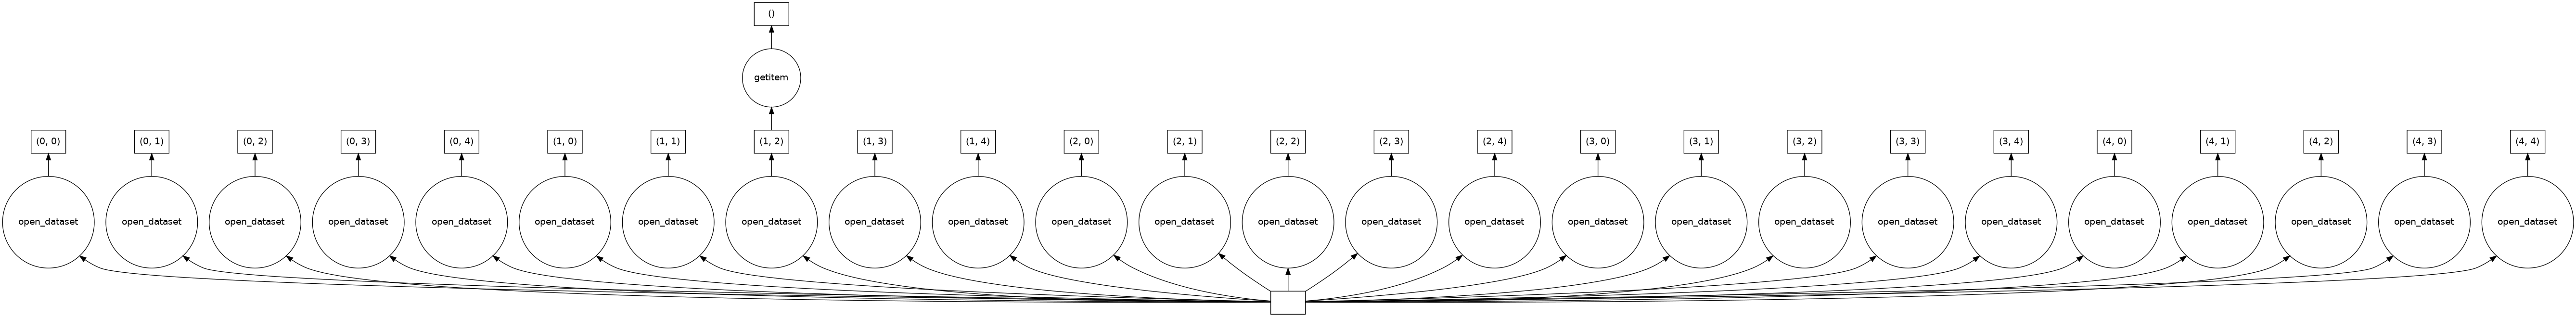

In [26]:
save=LTS.sel(lat=45.50, lon=9.36, method='nearest')['min']
save.data.visualize()

If you look onto the task graph, you can see that only one dask worker needs to read the data (only one chunk needs to be read). So most dask workers are doing some useless reads of data.
To avoid unecessary operations, we optimize the task graph using `optimize`, and verify the graph.

## Optimize the task graph

In [27]:
import dask

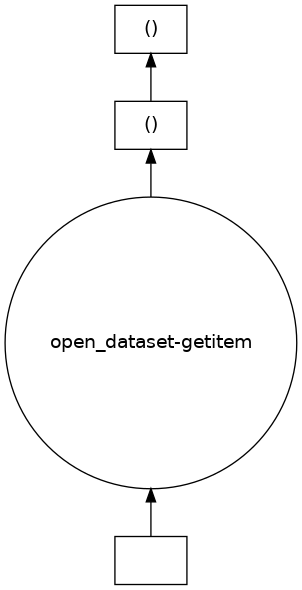

In [28]:
(save,) = dask.optimize(save)
save.data.visualize()

## Compute on the dask workers

In [29]:
save.compute()

<xarray.DataArray 'min' ()>
array(0.19200002, dtype=float32)
Coordinates:
    lon      float64 9.357
    lat      float64 45.5
Attributes:
    standard_name:  normalized_difference_vegetation_index
    long_name:      Minimum Normalized Difference Vegetation Index over time ...
    grid_mapping:   crs
    flag_meanings:  sea no_data
    flag_values:    [254 255]
    units:          
    valid_range:    [  0 250]
    cell_methods:   area: mean time: minimum

### Close client to terminate local dask cluster

The client will be automatically closed when your Python session ends. When using Jupyter notebooks, we recommend to close it explicitely whenever you are done with your local dask cluster.

In [ ]:
client.close()

## Set up Dask Gateway

When we want to scale out our data analysis and cannot only use the local machine, we need to be able to access a multi-node Dask cluster. 
On the EOSC Pangeo infrastructure, we can use Dask gateways to manage Dask clusters and run our data analysis in parallel e.g. distribute tasks across several workers.

In [1]:
from dask_gateway import Gateway # , BasicAuth
gateway = Gateway(
#    "http://api-daskhub-dask-gateway.daskhub:8000/",
#    auth = BasicAuth(password="pangeo_dask")
)

### Create a new Dask cluster on the Dask gateway

In [2]:
cluster = gateway.new_cluster()
cluster.scale(1)
cluster

## Get a client from the Dask Gateway Cluster

The Dask client is what allows you to interact with Dask. The Client will create the Directed Acyclic Graph (DAG) of tasks by analysing the code, and will be responsible for telling the scheduler what to compute. It will also gather results from the workers and aggregates the results in the Client process.

In [1]:
cluster = None # This is needed for building the Jupyter Book

In [ ]:
from distributed import Client

if cluster:
    client = Client(cluster) # create a dask Gateway cluster
else:
    client = Client()   # create a local dask cluster on the machine.
client

## Global LTS

In the previous episode, we used Long-term Timeseries for the region of Lombardy e.g. a very small area. Now we would like to use the original dataset that has a global coverage.

## Read from online kerchunked consolidated dataset

 We will access Long Term TimeSeries of NDVI statistics from OpenStack Object Storage using the Zarr metadata generated with kerchunk, prepared in [previous chunking_introduction](./chunking_introduction.ipynb) section .

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
catalogue="https://object-store.cloud.muni.cz/swift/v1/foss4g-catalogue/c_gls_NDVI-LTS_1999-2019.json"
LTS = xr.open_mfdataset(
    "reference://", engine="zarr",
    backend_kwargs={
        "storage_options": {
            "fo":catalogue
                    },
        "consolidated": False
    }
)
LTS

---- copy and past from chunking_introduction.ipynb begins we need to work on how to integrate it to this section ----

 

We can also postprocess LTS to get the dates properly set.

In [17]:
LTS = LTS.rename({'INDEX': 'time'}).assign_coords(time=time_list)
LTS

,Array,Chunk
Bytes,7.07 GiB,14.28 MiB
Shape,"(3, 15680, 40320)","(1, 1207, 3102)"
Count,508 Tasks,507 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,7.07 GiB,14.28 MiB
Shape,"(3, 15680, 40320)","(1, 1207, 3102)"
Count,508 Tasks,507 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [ ]:
import geopandas as gpd

In [ ]:
try:
    GAUL = gpd.read_file('Italy.geojson')
except:
    GAUL = gpd.read_file('zip+https://mars.jrc.ec.europa.eu/asap/files/gaul1_asap.zip') 

In [ ]:
AOI_name = 'Lombardia'
AOI = GAUL[GAUL.name1 == AOI_name]
AOI_poly = AOI.geometry
AOI_poly

In [ ]:
LTS = LTS.sel(lat=slice(46.5,44.5), lon=slice(8.5,11.5))
LTS = LTS.rio.write_crs(4326)

In [ ]:
LTS = LTS.rio.clip(AOI_poly, crs=4326)

In [ ]:
LTS

In [ ]:
%%time
LTS.compute()

## Visualize LTS statistics

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig = plt.figure(1, figsize=[15,5])

# Fix extent
minval = 0.0
maxval = 0.9

itime=0 # plot the first date

# Plot 1 for min subplot argument (nrows, ncols, nplot)
# here 1 row, 2 columns and 1st plot
ax1 = plt.subplot(1, 2, 1)
LTS.isel(time=itime)['min'].plot(ax=ax1)
# Plot 2 for max
# 2nd plot 
ax2 = plt.subplot(1, 2, 2)
LTS.isel(time=itime)['max'].plot(ax=ax2)

# Title for both plots
fig.suptitle('LTS NDVI statistics (Minimum and Maximum)', fontsize=20)




---- copy and past from chunking_introduction.ipynb begins we need to work on how to integrate it to this section ----

### Fix time coordinate

In [ ]:
dates_2022 = pd.date_range('20220101', '20221231')
decadie = dates_2022[np.isin(dates_2022.day, [1,11,21])]
LTS = LTS.assign_coords(time=decadie)
LTS

## Clip LTS over Lombardia

As in previous episodes, we use a shapefile over Italy to select data over this Area of Interest (AOI).

In [ ]:
import geopandas as gpd

In [ ]:
try:
    GAUL = gpd.read_file('Italy.geojson')
except:
    GAUL = gpd.read_file('zip+https://mars.jrc.ec.europa.eu/asap/files/gaul1_asap.zip') 

In [ ]:
AOI_name = 'Lombardia'
AOI = GAUL[GAUL.name1 == AOI_name]
AOI_poly = AOI.geometry
AOI_poly

We first select a geographical area that covers Lombardia and then clip using the shapefile.

In [ ]:
LTS = LTS.sel(lat=slice(46.5,44.5), lon=slice(8.5,11.5))

In [ ]:
LTS = LTS.rio.write_crs(4326)

In [ ]:
LTS = LTS.rio.clip(AOI_poly, crs=4326)

### Print metadata
We can print metadata without performing any computation yet. This is what we call *lazy* computation.

In [ ]:
LTS

## Compute

### Install additional packages in dask workers

In [ ]:
from distributed.diagnostics.plugin import PipInstall
extra_packages=["xarray", "netCDF4", "s3fs", "h5netcdf", "numpy", "zip", "pandas", "geopandas", "rioxarray", "rasterio", "scipy", "zarr"]

plugin=PipInstall(extra_packages,restart=True)
client.register_worker_plugin(plugin)

Verify the installation of package on dask worker.

In [ ]:
client.get_versions(packages=extra_packages,check=True)

In [ ]:
%%time
LTS_min = LTS['min']
(LTS_min,)=dask.optimize(LTS_min)
LTS_min.data.visualize()

In [ ]:
%%time
LTS_min.compute()

In [ ]:
%%time
LTS_max = LTS['max']
(LTS_max,)=dask.optimize(LTS_max)
LTS_max.data.visualize()

In [ ]:
%%time
LTS_max.compute()

## Get NDVI for 2022 over Lombardia

We re-use the file we created during the first episode. If the file is missing it will be downloaded from Zenodo.

In [ ]:
import pooch
try:
    cgls_ds = xr.open_dataset('C_GLS_NDVI_20220101_20220701_Lombardia_S3_2_masked.nc')
except:
    cgls_file = pooch.retrieve(
        url="https://zenodo.org/record/6969999/files/C_GLS_NDVI_20220101_20220701_Lombardia_S3_2_masked.nc",
        known_hash="md5:be3f16913ebbdb4e7af227f971007b22",
        path=f".",)    
    cgls_ds = xr.open_dataset(cgls_file)

In [ ]:
cgls_ds

In [ ]:
NDVI_AOI = cgls_ds.NDVI.rio.write_crs(4326)

In [ ]:
NDVI_AOI = NDVI_AOI.rio.clip(AOI_poly, crs=4326)

In [ ]:
NDVI_AOI

The nominal spatial resolution of the Long term statistics is 1km. As the current NDVI product has a nominal spatial resolution of 300m a re projection is needed. RioXarray through RasterIO that wraps the GDAL method can take care of this. More info about all the options can be found [here](https://rasterio.readthedocs.io/en/stable/api/rasterio.warp.html#rasterio.warp.reproject).

In [ ]:
NDVI_1k = NDVI_AOI.rio.reproject_match(LTS)

In [ ]:
NDVI_1k = NDVI_1k.rename({'x': 'lon', 'y':'lat'})

In [ ]:
VCI = ((NDVI_1k - LTS['min']) / (LTS['max'] - LTS['min'])) * 100

In [ ]:
VCI

In [ ]:
VCI.name = 'VCI'

In [ ]:
VCI

In [ ]:
%%time
VCI_c = VCI.compute()

In [ ]:
VCI.isel(time=-1).plot()

Now you have catalogue, original data source, both on cloud space, thus even from dask workers which do not have access to your NFS local disk space, data are accessible.
Now you are ready to parallelize your analysis using dask workers from dask gateway!

In [ ]:
client.close()

In [ ]:
cluster.shutdown()

## Packages citation

```{bibliography}
:style: alpha
:filter: topic % "dask" and topic % "package"
:keyprefix: e-
```